In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from itertools import compress
import seaborn as sns
import tkinter as tk
from scipy import stats  
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from tabulate import tabulate

### Prepare the final dataset

In [2]:
df = pd.read_csv(r'E:\19 Spring\Python Programming\finalpython\car_sale_ad.csv')
df.head()

,car,price,body,mileage,engType,registration,year,years since
0,Ford,15500.0,crossover,68,Gas,yes,2010,6
1,Mercedes-Benz,20500.0,sedan,173,Gas,yes,2011,5
2,Mercedes-Benz,35000.0,other,135,Petrol,yes,2008,8
3,Mercedes-Benz,17800.0,van,162,Diesel,yes,2012,4
4,Mercedes-Benz,33000.0,vagon,91,Other,yes,2013,3


#### Select the top 5 brands to analyze

In [3]:
dfcar = df['car'].value_counts()
dfcar.head()

Volkswagen       936
Mercedes-Benz    921
BMW              694
Toyota           541
VAZ              489
Name: car, dtype: int64

In [4]:
df = df[df['car'].isin(dfcar.index[:5])]

In [5]:
df['car'].value_counts()

Volkswagen       936
Mercedes-Benz    921
BMW              694
Toyota           541
VAZ              489
Name: car, dtype: int64

#### Exclude all prices that are 0

In [6]:
df = df[df['price'] != 0]

#### Save the final dataset

In [7]:
df.to_csv(r'E:\19 Spring\Python Programming\finalpython\car_final.csv')

### GUI Menu

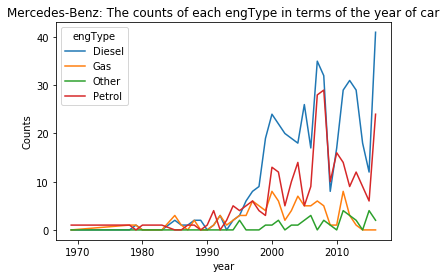

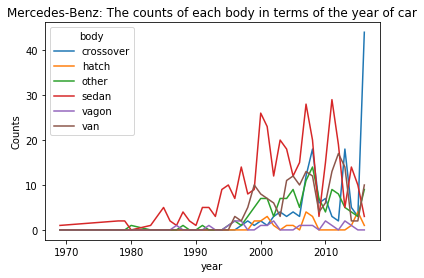

In [59]:
df = pd.read_csv(r'E:\19 Spring\Python Programming\finalpython\car_final.csv', index_col = 0) #read the file to analyze
# create the first window to ask people select whether they are customers or staffs, and then the next window will be different.
entry = tk.Tk()
entry.title('Hello!!!')

v1 = tk.IntVar()

entrychoice = ['Customer',
              'Staff']
def _entry():
    if v1.get() == 0: 
        radio = tk.Tk()#the second window for customers to select
        radio.title('Welcome to UCar')

        v2 = tk.IntVar()

        menuchoices = ['Know more about our cars', #customer can check the basic information of each brand
                      'Know the average price in terms of the year of car', #customer can check if the average price will be different in terms of the year of car
                      'Know the average prices of two brands'] #customer can check the average prices of two brands

        def Results(df):
            if v2.get() == 0:               
                radio_0 = tk.Tk() #the next window for the first choice to ask customers to choose a brand with radiobuttons
                radio_0.title('Know more about our cars')
                tk.Label(radio_0, text = 'Which brand are you interested in?', justify = tk.CENTER, font=("Helvetica", 15)).pack()
                v2_0 = tk.IntVar()
                
                car = list(df.car.unique())
                menuchoices = car
                def Results_0():#the function to make a line plot after selecting a brand
                    i = v2_0.get()
                    get_car = menuchoices[i]
                    dfa = df[df.car == get_car]
                    gal = ['engType', 'body']
                    for a in gal:
                        ga = pd.crosstab(dfa.year, dfa[a])
                        ga.plot(title = f'{get_car}: The counts of each {a} in terms of the year of car').set(ylabel = 'Counts')
                        plt.show()


                for val, choice in enumerate(menuchoices):
                    tk.Radiobutton(radio_0,
                                  text = choice,
                                  variable = v2_0,
                                  value = val, padx = 20, command = Results_0).pack(anchor = tk.W)

                button1 = tk.Button(radio_0, text = 'OK', width = 25, command = radio_0.destroy)
                button1.pack()
                
                radio_0.mainloop()
                Results_0()
                
            elif v2.get() == 1:
                A_1 = tk.Tk() #a new window to check the average price with the button
                A_1.title('PRICE')
                
                y = df['year'].max()
                ylist = [y-2, y-1, y]                  
                def A():
                    a = {}
                    a1 = pd.DataFrame()
                    for n, i in enumerate(ylist):
                        a[n] = df[df['year'] == i]
                        a1 = pd.concat([a1, a[n]], sort = True)
                    f, p_val = stats.f_oneway(a[0].price, a[1].price, a[2].price) #leverage ANOVA to test the mean price in different groups
                    if p_val < 0.05:
                        print("The average prices are different in terms of the year of car") #if different, check which 2 groups are different 
                        tukey = pairwise_tukeyhsd(endog=a1['price'],
                                                  groups=a1['year'],
                                                  alpha=0.5)
                        print(tukey.summary())

                        
                    else:
                        print("The average prices are same in terms of the year of car")
                        
                    tukey.plot_simultaneous() #visualize the means
                    plt.vlines(x=a1['price'].mean(),ymin=-0.5,ymax=2.5, color="red")
                    plt.yticks(np.arange(len(ylist)), ylist)
                    plt.show()
                    
                tk.Label(A_1,
                        text = f'The year of car is from {ylist[0]} to {ylist[-1]}',
                        justify = tk.CENTER, font=("Helvetica", 15)).pack()
                Button = tk.Button(A_1, text = 'Entry',
                                   command = A)
                Button.pack()
                Buttonquit = tk.Button(A_1, text = 'Quit',
                                      command = A_1.destroy)
                Buttonquit.pack()                
                
                A_1.mainloop()
        
            else:
                check_2 = tk.Tk() #a new window to check the average price of two brands with checkbuttons
                check_2.title('Compare the average price of our cars!')
                tk.Label(check_2, text = 'Please check only two brands', justify = tk.CENTER, font=("Helvetica", 15)).pack()
                car = list(df.car.unique())
                menuchoices = car
                
                vars = []
                alpha = 0.5
                for i in car:
                    var = tk.BooleanVar()
                    tk.Checkbutton(check_2, text = i, variable = var, padx = 20).pack(anchor = tk.W)
                    vars.append(var)               
                
                def ttest(): #use t-test to test the mean prices between two brands(assuming the variances are same)
                    a = map((lambda var: var.get()), vars)
                    a = list(a)
                    if a.count(True) == 2:
                        c = list(compress(car, a))
                                
                        y1 = df['price'][df.car == c[0]]
                        y2 = df['price'][df.car == c[1]]
                        
                        tmean, p_valmean = stats.ttest_ind(y1, y2, equal_var=True)        
                        if p_valmean < alpha:
                                print(f"The average prices between {c[0]} and {c[1]} are not equal")
                        else:
                                print(f"The average prices between {c[0]} and {c[1]} are equal")  
                        b = df[df['car'].isin(c)]
                        sns.boxplot(x = b.car, y = b.price)
                        sns.stripplot(x=b.car, y=b.price, color="orange", jitter=0.2, size=2.5)

                        plt.show()
                        
                    else: #warning if customers don't do the right selections
                        print('Warning! choosing only two brands!')
                        
                
                Button = tk.Button(check_2, text = 'OK', command = ttest)
                Button.pack()

                    
                check_2.mainloop()

                

        tk.Label(radio,
                text = '''Choose your interests:''',
                justify = tk.CENTER, font=("Helvetica", 15)).pack()

        for val, choice in enumerate(menuchoices):
            tk.Radiobutton(radio,
                          text = choice,
                          padx = 20,
                          variable = v2,
                          value = val).pack(anchor = tk.W)
        button = tk.Button(radio, text = 'OK', width = 25, command = radio.destroy)
        button.pack()

        radio.mainloop()
        
        Results(df)
    else:#
        radio1 = tk.Tk() #a window for staff after selecting the staff radiobutton
        radio1.title('\nDo best price for customers')

        v3 = tk.IntVar()
        v3.set(0)

        menuchoices = ['How could we predict our price', #use linear regression the create a model
                      'Look up the price'] #look up a price quickly for customers

        def Results1(df):
            if v3.get() == 0:
                radio1_0 = tk.Tk()#a new window for staffs to select the predictors with checkbuttons
                radio1_0.title('Know the relationship with the price of our cars')          
                tk.Label(radio1_0,
                        text = 'Which predictor you want to use?',
                        justify = tk.CENTER, font = ("Helvetica", 15)).pack()
                pred = list(df.columns)
                pred.remove('price')
                pred.remove('year') 
                
                vars = []
                
                for i in pred:
                    v3_0 = tk.BooleanVar()
                    tk.Checkbutton(radio1_0, text = i, variable = v3_0, padx = 20).pack(anchor = tk.W)
                    vars.append(v3_0)
                    
                def reg(): #linear regression
                    Ba = map((lambda v3_0: v3_0.get()), vars)
                    Ba = list(Ba)
                    #predictors chosen
                    c = list(compress(pred, Ba))
                    cl = len(c)
                    if cl == 1:
                        model = ols('df.price ~ df[c[0]]', data = df).fit()
                        print(f'c[0]: {c[0]}')
                        print(model.summary())      
                        
                    elif cl == 2:
                        model = ols('df.price ~ df[c[0]] + df[c[1]]', data = df).fit()
                        print(f'c[0]: {c[0]}, c[1]: {c[1]}')
                        print(model.summary()) 
                        
                    elif cl == 3:
                        model = ols('df.price ~ df[c[0]] + df[c[1]] + df[c[2]]', data = df).fit()
                        print(f'c[0]: {c[0]}, c[1]: {c[1]}, c[2]: {c[2]}')
                        print(model.summary()) 
                        
                    elif cl == 4:
                        model = ols('df.price ~ df[c[0]] + df[c[1]] + df[c[2]] + df[c[3]]', data = df).fit()
                        print(f'c[0]: {c[0]}, c[1]: {c[1]}, c[2]: {c[2]}, c[3]: {c[3]}')
                        print(model.summary())     
                        
                    elif cl == 5:
                        model = ols('df.price ~ df[c[0]] + df[c[1]] + df[c[2]] + df[c[3]] + df[c[4]]', data = df).fit()
                        print(f'c[0]: {c[0]}, c[1]: {c[1]}, c[2]: {c[2]}, c[3]: {c[3]}, c[4]: {c[4]}')
                        print(model.summary()) 
                        
                    elif cl == 6:
                        model = ols('df.price ~ df[c[0]] + df[c[1]] + df[c[2]] + df[c[3]] + df[c[4]] + df[c[5]]', data = df).fit()
                        print(f'c[0]: {c[0]}, c[1]: {c[1]}, c[2]: {c[2]}, c[3]: {c[3]}, c[4]: {c[4]}, c[5]: {c[5]}')
                        print(model.summary()) 
                    
                    
                    else: 
                        print('Warning! Please choose one predictor!')
                    #make residual plots to check assumption
                    yvar = 'price'
                    y = df[yvar]
                    r2adj = round(model.rsquared_adj,2)
                    p_val = round(model.f_pvalue,4)
                    coefs = model.params
                    coefsindex = coefs.index
                    regeq = round(coefs[0],3)
                    cnt = 1
                    for i in coefs[1:]:
                        regeq=f"{regeq} {round(i,3)} {coefsindex[cnt]}"
                        cnt = cnt + 1
                    predict_y = model.predict()
                    plt.scatter(y,predict_y)
                    minSls=y.min()
                    maxSls=y.max()
                    diag = np.arange(minSls,maxSls,(maxSls-minSls)/50)
                    plt.scatter(diag,diag,color='red',label='perfect prediction')
                    plt.suptitle(regeq)
                    plt.title(f' with adjR2: {r2adj}, F p-val {p_val}',size=10)
                    plt.xlabel(y.name)
                    plt.ylabel('Predicted ' + y.name)
                    plt.legend(loc='best')
                    plt.show()
                        

                    resid = model.resid
                    predict_y = model.predict()
                    plt.scatter(predict_y, resid)
                    plt.suptitle(regeq)
                    plt.hlines(0,predict_y.min(),predict_y.max()) 
                    plt.ylabel('Residuals')
                    plt.xlabel('Predicted ' + yvar)
                    plt.show()
                

                button = tk.Button(radio1_0, text = 'OK', width = 25, command = reg)
                button.pack()                
                button1 = tk.Button(radio1_0, text = 'Quit', width = 25, command = radio1_0.destroy)
                button1.pack()  
                
                radio1_0.mainloop()
                
            else:
                carlb = tk.Tk() #a new window to filter and get the price with list boxs
                carlb.title('Choose a car')
                tk.Label(carlb, text = 'Double click a car', padx = 20, justify = tk.CENTER).pack(anchor = tk.W)
                def printList(event): #staff's selection beginning with car, then year, body, and engType
                    car = lb.get(lb.curselection())
                    df1 = df[df.car == car]
    
                    yearlb = tk.Tk()
                    yearlb.title('Choose a year')
                    tk.Label(yearlb, text = 'Double click a year', padx = 20, justify = tk.CENTER).pack(anchor = tk.W)
                    yearlist = list(df1.year.unique())
                    yearlist.sort(reverse=True)
                    def printList(event):       
                        year = lb1.get(lb1.curselection())
                        df2 = df1[df1.year == int(year)]
                        
                        bodylb = tk.Tk()
                        bodylb.title('Choose a body')
                        tk.Label(bodylb, text = 'Double click a body', padx = 20, justify = tk.CENTER).pack(anchor = tk.W)
                        bodylist = list(df2.body.unique())
                        def printList(event):
                            body = lb2.get(lb2.curselection())
                            df3 = df2[df2.body == body]
                            
                            englb = tk.Tk()
                            englb.title('Choose an engine type')
                            tk.Label(englb, text = 'Double click an engine type', padx = 20, justify = tk.CENTER).pack(anchor = tk.W)
                            englist = list(df3.engType.unique())
                            def printList(event):
                                eng = lb3.get(lb3.curselection())
                                df4 = df3[df3.engType == eng]
                                
                                final = tk.Tk()
                                final.title('Get Price!')
                                tk.Label(final, text = 'Good Price!!!', compound = 'center', font=("Helvetica", 30)).pack()
                                def price(): #finally, we can get a table with all information
                                    print(tabulate(df4, headers = list(df4.columns), tablefmt = 'rst'))
                                    
                                button = tk.Button(final, text = 'OK', width = 25, command = price)
                                button.pack()                                    
                                    
                            lb3 = tk.Listbox(englb)
                            lb3.bind('<Double-Button-1>',printList)
                            for i in englist:
                                lb3.insert('end', i)
                            lb3.pack(anchor = tk.W)

                            lb3.mainloop()
                        lb2 = tk.Listbox(bodylb)
                        lb2.bind('<Double-Button-1>',printList)
                        for i in bodylist:
                            lb2.insert('end', i)
                            
                        lb2.pack(anchor = tk.W)
                        lb2.mainloop()
                    lb1 = tk.Listbox(yearlb)
                    lb1.bind('<Double-Button-1>',printList)
                    for i in yearlist:
                        lb1.insert('end', i)
                    lb1.pack(anchor = tk.W)
                    lb1.mainloop()
    
                lb = tk.Listbox(carlb)
                lb.bind('<Double-Button-1>',printList)
                carlist = list(df.car.unique())
                for i in carlist:
                    lb.insert('end',i)
                lb.pack(anchor = tk.W)
                carlb.mainloop()


        tk.Label(radio1,
                text = 'Always offer the best price',
                justify = tk.CENTER, font=("Helvetica", 15)).pack()

        for val, choice in enumerate(menuchoices):
            tk.Radiobutton(radio1,
                          text = choice,
                          variable = v3,
                          value = val, padx = 20).pack(anchor = tk.W)
        button = tk.Button(radio1, text = 'Get Price', width = 25, command = radio1.destroy)
        button.pack()
        
        radio1.mainloop()
        Results1(df)   
    
logo = tk.PhotoImage(file=r"E:\19 Spring\Python Programming\finalpython\aa.gif")
tk.Label(entry, text = 'Welcome to UCar!!!', compound = 'center', font=("Helvetica", 30),image = logo).pack()

for val, choice in enumerate(entrychoice):
    tk.Radiobutton(entry,
                  text = choice,
                  variable = v1,
                  value = val, padx = 20, font=("Helvetica", 15)).pack(anchor = tk.W)
button = tk.Button(entry, text = 'GO!', width = 25, command = entry.destroy)
button.pack()
 
entry.mainloop()
_entry()

### Demostration of my project

In [24]:
os.chdir(r'E:\19 Spring\Python Programming\finalpython')

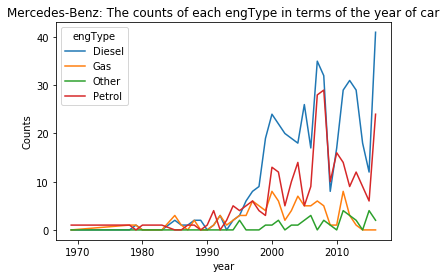

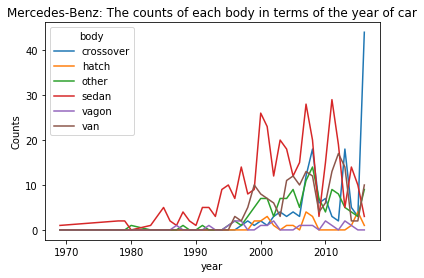

In [60]:
%run FP.py

The average prices are different in terms of the year of car
  Multiple Comparison of Means - Tukey HSD,FWER=0.50 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
 2014   2015  11051.4714 3962.5868  18140.356   True 
 2014   2016  33515.599  27610.485  39420.7129  True 
 2015   2016  22464.1276 15935.6727 28992.5824  True 
-----------------------------------------------------


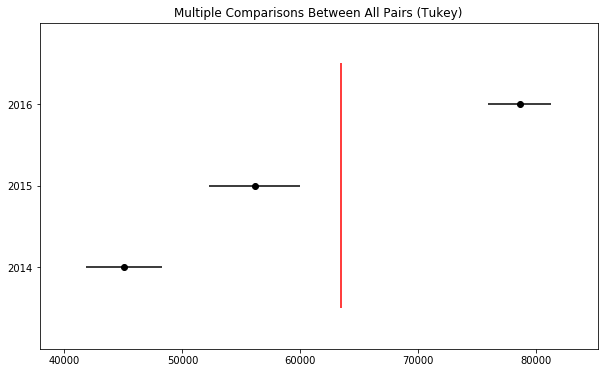

In [50]:
%run FP.py

The average prices between Mercedes-Benz and BMW are not equal


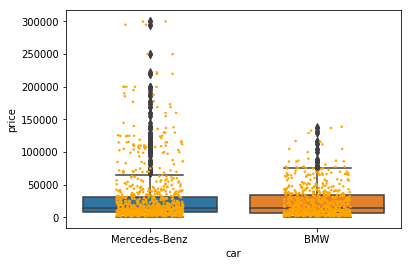

In [61]:
%run FP.py

c[0]: body, c[1]: years since
                            OLS Regression Results                            
Dep. Variable:               df.price   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     268.0
Date:                Thu, 13 Jun 2019   Prob (F-statistic):          8.73e-282
Time:                        13:53:24   Log-Likelihood:                -39298.
No. Observations:                3432   AIC:                         7.861e+04
Df Residuals:                    3425   BIC:                         7.865e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercep

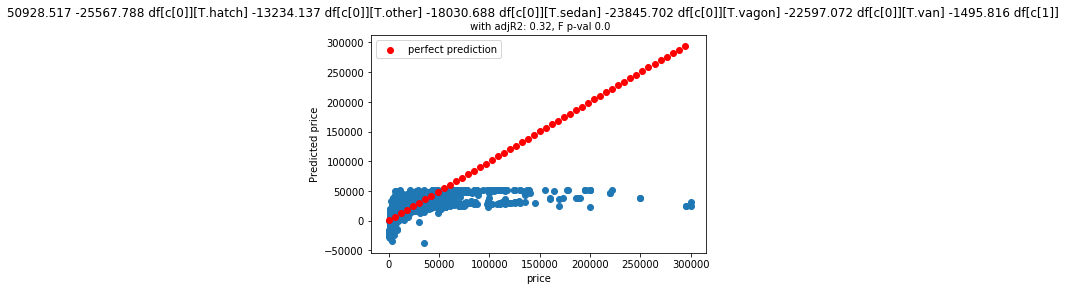

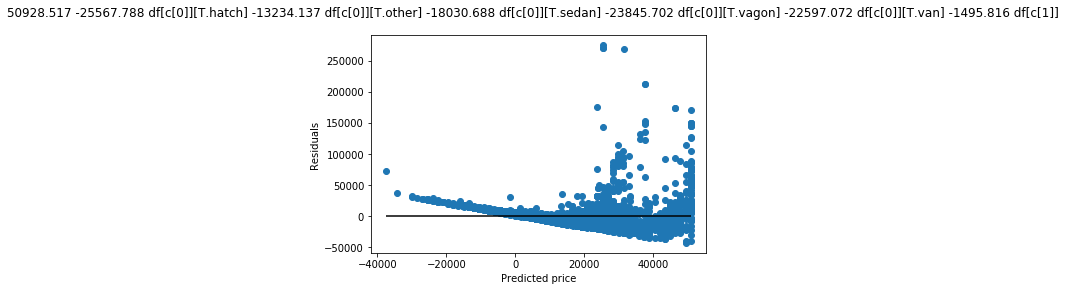

In [58]:
%run FP.py

In [62]:
%run FP.py

====  =============  =======  =========  =========  =========  ==============  ======  =============
  ..  car              price  body         mileage  engType    registration      year    years since
====  =============  =======  =========  =========  =========  ==============  ======  =============
  17  Mercedes-Benz    99999  crossover          0  Petrol     yes               2016              0
1786  Mercedes-Benz   199999  crossover          0  Petrol     yes               2016              0
2022  Mercedes-Benz   199999  crossover          0  Petrol     yes               2016              0
2145  Mercedes-Benz   177000  crossover          0  Petrol     yes               2016              0
2790  Mercedes-Benz   195000  crossover          2  Petrol     yes               2016              0
3103  Mercedes-Benz   177777  crossover          0  Petrol     yes               2016              0
3281  Mercedes-Benz   199999  crossover          0  Petrol     yes               2016      

### Presentation of my project

##### Highlights

In my menu, customers and staffs can see different choices. Also, they can check any information by justing click what they are interested in. <br>
I used different widgets, like radiobutton, listbox, checkbutton, radiobutton. <br>
I used seaborn package to make visualization on some outputs. <br>

##### Good experiences

I understand more about each widget.

##### Bad experiences

I still cannot figure out how to change the index of parameters in regression summary <br>
The image in my first window doesn't work sometimes. <br>